In [1]:
import random
from typing import Union

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import transformers

In [2]:
# ######################## PART 3: YOUR WORK HERE ########################
"""
3. Open-domain question answering (45 pts)
In this part, you will need to implement a model similar to Dense Passage Retrieval for
Open-Domain Question Answering by Karpukhin et al (2020). Before starting, please go over
the paper, and optionally read this blog post section on open-domain QA and skim over the
DPR code repository.
For the assignment, you are given CSV files in data/qa that correspond to the training Q&A
pairs, validation pairs, test questions, and answers.csv that contains all the answers. The data is
taken from a Q&A forum about cooking, and at the end of this section you will have built a
model that can automatically retrieve (i.e. search) relevant answers for any question about
cooking.
"""


def load_models_and_tokenizer(q_name, a_name, t_name, device='cuda'):
    """
    In part 1, you used an object-oriented approach to load a custom distilbert model. This time, you
    need to load two models (one for encoding the questions, another for encoding the candidate
    answers, and they have separate weights but same embedding dimensions). You will use a
    simpler approach this time; simply build functions that load and return the models, perform
    slicing, and generate tokens, all separate from OOP.
    load_models_and_tokenizer
    For this, we will be testing with the string 'google/electra-small-discriminator' but
    your function should work with other names as well. You do not review ELECTRA, other than
    knowing that this is a pretrained model that performs well but is much smaller than DistilBERT
    and has smaller embedding size. You should be comfortable loading other models from
    Huggingface, as hundreds of them exist.
    ParameterTypeDescription
    q_namestrName of the model that will be passed to transformers to
    automatically load the pre-trained version, and used for encoding
    questions. It must be something that can be found on
    Huggingface Hub, just like you’ve previously done.
    a_namestrName of the model encoding the answers.
    t_namestrName of the tokenizer, which will be passed to transformers to
    automatically load the corresponding pre-trained tokenizer.
    devicestr“cuda” or “cuda”, the models will be loaded here.
    ReturnsType
    Descriptionq_enctransformers
    ModelThe question encoder model, which is a huggingface
    transformer. This corresponds to q_name
    a_enctransformers
    ModelThe candidate answers the encoder model, which is a
    huggingface transformer. This corresponds to a_name
    tokenizertransformers
    tokenizerThe tokenizer that will be used for each of the models. For
    simplicity, it will be shared, but in theory you could have
    separate tokenizers if you use different models for
    encoding questions and answers, but this is rare in
    practice.
    :param q_name:
    :param a_name:
    :param t_name:
    :param device:
    :return:
    """
    # TODO: your work below
    q_enc = transformers.ElectraModel.from_pretrained(q_name).to(device)
    a_enc = transformers.ElectraModel.from_pretrained(a_name).to(device)
    tokenizer = transformers.ElectraTokenizer.from_pretrained(t_name)
    return q_enc, a_enc, tokenizer


def tokenize_qa_batch(tokenizer, q_titles, q_bodies, answers, max_length=64):
    """
    tokenize_qa_batch
    Tokenize question titles/bodies and answers into two input batches. The following conditions
    apply:
    ● The input_ids returned should be Pytorch tensors
    ● The content should be truncated using the default method if it exceeds max_length
    ● You should only pad everything to the longest sequence in a batch
    ● The title and body should be tokenized together as a pair, separated with a [SEP] token.
    ● The answers should be tokenized separately
    ● q_titles,q_bodies, answers are all lists of the same length
    ParameterTypeDescription
    tokenizertransformers
    tokenizerA huggingface tokenizer returned by your previous
    function.
    q_titleslist of strThe list of titles of the questions
    q_bodieslist of strThe list of questions bodies (actual content)
    answerslist of strThe contents of the corresponding answers
    max_lengthintThe maximum length of the tokens, after which it is
    truncated
    ReturnsTypeDescription
    q_batchBatchEncodingA "BatchEncoding" (inherited from a dict) containing
    the question titles and bodies, which can be used as
    the input of a transformer model (which means the
    input IDs are PyTorch tensors)
    a_batch
    BatchEncoding
    A "BatchEncoding" (inherited from a dict) containing
    the answer bodies, which can be used as the input of a
    transformer model.
    :param tokenizer:
    :param q_titles:
    :param q_bodies:
    :param answers:
    :param max_length:
    :return:
    """
    # TODO: your work below.
    q_batch = tokenizer(
        q_titles,
        q_bodies,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    a_batch = tokenizer(
        answers,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    return q_batch, a_batch


def get_class_output(model, batch):
    """
    Since this is similar to a previous question, it is left ungraded.
    ReturnsDescription
    BaseModelOutputThe output representation of the class token (for example [CLS])
    after encoding the tokenized text through your model.
    :param model:
    :param batch:
    :return:
    """
    # Since this is similar to a previous question, it is left ungraded
    # TODO: your work below.
    return model(**batch, return_dict=True).last_hidden_state[:, 0, :]


def inbatch_negative_sampling(Q: Tensor, P: Tensor, device: str = 'cuda') -> Tensor:
    """
    3.3 Batch: Implement in-batch negative sampling (7 pts)
    The in-batch negative sampling method uses the answers from other questions in the same
    batch as the negative examples (because they are unrelated as they are randomly taken from
    the training set). Please read the relevant section in the paper and implement it accordingly.
    inbatch_negative_sampling
    This function should take the tensors of questions Q and passages P, and use the in-batch
    negatives (as described in the paper) to compute a similarity matrix evaluated on each of the N
    questions with the M passages. Although we call it “sampling”, you are computing it over all
    passages in a batch rather than taking a subsample of the batch. You can find a way to do both
    the “negative sampling” and computing similarity at the same time; you can read the paper to
    find out how to do that.
    ParameterTypeDescription
    QTensor[N, E]The output representation of N question titles+bodies
    PTensor[M, E]The output representation of M answers (aka passages)
    devicestr“cuda” or “cuda”, the models will be loaded here.
    ReturnsDescription
    Tensor[N, M]The matrix of similarity score that results from in-batch negative
    sampling.
    :param Q:
    :param P:
    :param device:
    :return:
    """
    # TODO: your work below
    Q = Q.to(device)
    P = P.to(device)
    return torch.matmul(Q, P.T)


def contrastive_loss_criterion(S: Tensor, labels: Tensor = None, device: str = 'cuda'):
    """
    Contrastive loss is different from the loss functions we have previously been exposed to. You
    have previously seen loss functions for classification and for text generation, but retrieval
    requires something different. You will need to implement the loss function described in the DPR
    paper (please read the equations carefully), and the official source code shows how to
    implement it in Pytorch.
    contrastive_loss_criterion
    ParameterTypeDescription
    STensor[N, M]The matrix of similarity score that results from in-batch
    negative sampling.
    labelsTensor[N]The optional label indices between 0-M. For example [0, 2,
    M,..., 1] respectively indicate that the
    ● Passage #0 is the answer for Question #0
    ● Passage #2 is the answer for Question #1
    ● Passage #M is the answer for Question #2
    ● …
    ● Passage #1 is the answer for Question #N
    If labels=None, simply return a tensor with values such at
    Passage #0 corresponds to Question #0, P1 with Q1, etc.
    devicestr“cuda” or “cuda”, the models will be loaded here.
    ReturnsDescription
    Tensor(1)A scalar tensor on which you can call backward to initiate the backprop
    process. The value represents the loss, which means a lower value
    means the model has a low error when matching the questions with the
    passages.
    :param S:
    :param labels:
    :param device:
    :return:
    """
    # TODO: your work below
    if labels is None:
        labels = torch.arange(S.size(0), device=device)
    return torch.nn.functional.cross_entropy(S, labels)


def get_topk_indices(Q, P, k: int = None):
    """
    get_topk_indices
    Compute the dot-product similarity score (without normalizing or cosine scaling) and return the
    indices and scores for the top-k candidate answers for each question in Q.
    ParameterTypeDescription
    QTensor[N, E]The output class representation for question title+body
    PTensor[M, E]The output class representation for answer (aka
    passage)
    kintThe number of indices to return based on the similarity.When k=None, simply return everything in the sorted
    order.
    ReturnsTypeDescription
    indicesTensor[N, k] of intThe sorted indices of the most similar answers for each
    of N questions (from largest to smallest magnitude)
    scoresTensor[N, k] of intThe dot-product similarity score for the corresponding
    indices
    :param Q:
    :param P:
    :param k:
    :return:
    """
    # TODO: your work below
    scores = torch.matmul(Q, P.T)
    indices = torch.argsort(scores, dim=1, descending=True)
    if k is not None:
        indices = indices[:, :k]
        scores = scores.gather(1, indices)
    return indices, scores


def select_by_indices(indices: Tensor, passages: 'list[str]') -> 'list[str]':
    """
        select_by_indices
    ParameterTypeDescription
    indicesTensor[N, k] of intThe sorted indices of the most similar answers for each
    of N questions (from largest to smallest magnitude)
    passageslist of strA list of answers in the original textual format (before
    tokenization). The length should be greater than the
    largest index in indices (i.e. M).
    Returns
    Description
    list of list of str
    ●
    ●
    The outer lists correspond to answers for the the N questions
    The inner lists contain the k sorted answers in original text format
    :param indices:
    :param passages:
    :return:
    """
    # TODO: your work below
    return [[passages[i] for i in idx] for idx in indices]


def embed_passages(passages: 'list[str]', model, tokenizer, device='cuda', max_length=512):
    """
    First, set the model into the evaluation mode and disable gradients, then embed a list of
    passages.
    ParameterTypeDescription
    passageslist of strA list of answers in the original textual format (before
    tokenization). The length should be greater than the largest index
    in indices (i.e. M).
    modelThe Huggingface transformer model used to encode the text
    tokenizerThe Huggingface tokenizer used to encode the passages
    Returns
    Description
    Tensor[M, E]
    The output class representation for answer (aka passage)
    :param passages:
    :param model:
    :param tokenizer:
    :param device:
    :param max_length:
    :return:
    """
    # TODO: your work below
    model.to(device)
    model.eval()
    with torch.no_grad():
        encoded_passages = tokenizer(passages, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
        outputs = model(**encoded_passages, return_dict=True)
        passage_embeddings = outputs.last_hidden_state[:, 0, :]
    return passage_embeddings


def embed_questions(titles, bodies, model, tokenizer, device='cuda', max_length=512):
    """
    First, set the model into the evaluation mode and disable gradients. Then, embed titles and
    bodies at the same time using the question model (review BERT to see how this is possible).
    ParameterTypeDescription
    titleslist of strA list of titles in the original textual format (before tokenization).
    The length should be greater than the largest index in indices (i.e.
    M).
    bodieslist of strThe bodies corresponding to each title.
    modelThe Huggingface transformer model used to encode the text
    tokenizerThe Huggingface tokenizer used to encode the passages
    ReturnsDescription
    Tensor[N, E]The output class representation for questions (titles with bodies)
    :param titles:
    :param bodies:
    :param model:
    :param tokenizer:
    :param device:
    :param max_length:
    :return:
    """
    # TODO: your work below
    model.to(device)
    model.eval()
    with torch.no_grad():
        # Combine titles and bodies with the [SEP] token
        combined_texts = ["[CLS] " + title + " [SEP] " + body for title, body in zip(titles, bodies)]
        encoded_questions = tokenizer(combined_texts, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
        outputs = model(**encoded_questions, return_dict=True)
        question_embeddings = outputs.last_hidden_state[:, 0, :]  # Use the pooled output for question embeddings
    return question_embeddings


def recall_at_k(retrieved_indices: 'list[list[int]]', true_indices: 'list[int]', k: int):
    """
    You can review the recall score here. Note that since we are returning k elements, we want to
    know if the correct answer is in one of the k elements, hence we are calling this the “recall”
    score, though it might feel different from how we use recall for binary classification.
    ParameterTypeDescription
    retrieved_indiceslist of list of
    intouter list: The retrieved results for each of N questions
    inner list: The k indices ranked in order of estimated
    relevance
    true_indiceslist of intThe correct index for each of N questions, same length as
    retrieved_indices’s outer list
    kintThe number of inner items in retrieved_indices to consider;
    k must be smaller than the length of the inner lists
    ReturnsDescriptionfloat
    A single score representing the recall at k score
    :param retrieved_indices:
    :param true_indices:
    :param k:
    :return:
    """
    # TODO: your work below
    return sum([1 if true in retrieved[:k] else 0 for retrieved, true in zip(retrieved_indices, true_indices)]) / len(retrieved_indices)


def mean_reciprocal_rank(retrieved_indices: 'list[list[int]]', true_indices: 'list[int]'):
    """
    Please refer to recall_at_k, except you are now returning the Mean Reciprocal Rank, and
    there’s no parameter k. You can read more about this on Wikipedia. The mean reciprocal rank is a statistic measure
    for evaluating any process that produces a list of possible responses to a sample of queries, ordered by probability
    of correctness. The reciprocal rank of a query response is the multiplicative inverse of the rank of the first
    correct answer: 1 for first place, 1⁄2 for second place, 1⁄3 for third place and so on. The mean reciprocal rank is
    the average of the reciprocal ranks of results for a sample of queries Q
    :param retrieved_indices:
    :param true_indices:
    :return:
    """
    # TODO: your work below
    assert len(retrieved_indices) == len(true_indices), "Length of retrieved_indices and true_indices must be equal."

    reciprocal_ranks = []
    for retrieved, true in zip(retrieved_indices, true_indices):
        if true in retrieved:
            rank = retrieved.index(true) + 1
            reciprocal_ranks.append(1 / rank)
        else:
            reciprocal_ranks.append(0)

    return sum(reciprocal_ranks) / len(reciprocal_ranks)

In [3]:
import pandas as pd
from sklearn.metrics import accuracy_score  # Make sure sklearn is installed

random.seed(2022)
torch.manual_seed(2022)

# Parameters (you can change them)
sample_size = 2500  # Change this if you want to take a subset of data for testing
batch_size = 64
n_epochs = 10
num_words = 50000

# If you use GPUs, use the code below:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ###################### PART 3: TEST CODE ######################
# Preliminary
bsize = 8
qa_data = dict(
    train=pd.read_csv('data/qa/train.csv'),
    valid=pd.read_csv('data/qa/validation.csv'),
    answers=pd.read_csv('data/qa/answers.csv'),
)

# Loading huggingface models and tokenizers
name = 'google/electra-small-discriminator'
q_enc, a_enc, tokenizer = load_models_and_tokenizer(q_name=name, a_name=name, t_name=name)
q_enc = q_enc.to(device)
a_enc = a_enc.to(device)

# Get optimizer
optimizer = torch.optim.Adam(list(q_enc.parameters()) + list(a_enc.parameters()), lr=1e-5)

# Report your results on open-domain question answering similar to part 1. Train your model for 10 epochs, and compute the evaluation scores at the end of an epoch. Please read all subsections before starting your report.
train_recall = []
valid_recall = []
train_mrr = []
valid_mrr = []
for epoch in range(n_epochs):
    for i in range(0, len(qa_data['train']), batch_size):
        # Get batch
        q_titles = qa_data['train'].loc[i : i + batch_size, 'QuestionTitle'].tolist()
        q_bodies = qa_data['train'].loc[i : i + batch_size, 'QuestionBody'].tolist()
        answers = qa_data['train'].loc[i : i + batch_size, 'Answer'].tolist()
        # Tokenize batch and get class output
        q_batch, a_batch = tokenize_qa_batch(tokenizer, q_titles, q_bodies, answers)
        q_batch = q_batch.to(device)
        a_batch = a_batch.to(device)

        q_out = get_class_output(q_enc, q_batch)
        a_out = get_class_output(a_enc, a_batch)

        # Compute similarity matrix
        S = inbatch_negative_sampling(q_out, a_out)

        # Compute loss
        loss = contrastive_loss_criterion(S)

        # Backprop
        loss.backward()
        # Update weights
        optimizer.step()
        # Zero gradients
        optimizer.zero_grad()
    # Compute evaluation scores on entire train and validation set
    q_titles = qa_data['train'].loc[:100, 'QuestionTitle'].tolist()
    q_bodies = qa_data['train'].loc[:100, 'QuestionBody'].tolist()
    answers = qa_data['train'].loc[:100, 'Answer'].tolist()
    # Tokenize batch and get class output
    q_batch, a_batch = tokenize_qa_batch(tokenizer, q_titles, q_bodies, answers)
    q_batch = q_batch.to(device)
    a_batch = a_batch.to(device)
    q_out = get_class_output(q_enc, q_batch)
    a_out = get_class_output(a_enc, a_batch)
    # Get top-k indices
    indices, scores = get_topk_indices(q_out, a_out, k=10)
    indices = indices.cpu().tolist()
    # Select by indices
    selected = select_by_indices(indices, answers)
    # Compute recall at k
    recall = recall_at_k(indices, list(range(len(answers))), k=10)
    # Compute mean reciprocal rank
    mrr = mean_reciprocal_rank(indices, list(range(len(answers))))
    print(f"Epoch {epoch + 1} - Recall@10: {recall:.4f}, MRR: {mrr:.4f}")
    train_recall.append(recall)
    train_mrr.append(mrr)

    # Validation
    q_titles = qa_data['valid'].loc[:100, 'QuestionTitle'].tolist()
    q_bodies = qa_data['valid'].loc[:100, 'QuestionBody'].tolist()
    answers = qa_data['valid'].loc[:100, 'Answer'].tolist()
    # Tokenize batch and get class output
    q_batch, a_batch = tokenize_qa_batch(tokenizer, q_titles, q_bodies, answers)
    q_batch = q_batch.to(device)
    a_batch = a_batch.to(device)
    q_out = get_class_output(q_enc, q_batch)
    a_out = get_class_output(a_enc, a_batch)
    # Get top-k indices
    indices, scores = get_topk_indices(q_out, a_out, k=10)
    indices = indices.cpu().tolist()
    # Select by indices
    selected = select_by_indices(indices, answers)
    # Compute recall at k
    recall = recall_at_k(indices, list(range(len(answers))), k=10)
    # Compute mean reciprocal rank
    mrr = mean_reciprocal_rank(indices, list(range(len(answers))))
    print(f"Epoch {epoch + 1} - Recall@10: {recall:.4f}, MRR: {mrr:.4f}")
    valid_recall.append(recall)
    valid_mrr.append(mrr)


Epoch 1 - Recall@10: 0.2970, MRR: 0.0935
Epoch 1 - Recall@10: 0.2772, MRR: 0.0923
Epoch 2 - Recall@10: 0.4455, MRR: 0.2298
Epoch 2 - Recall@10: 0.4158, MRR: 0.1667
Epoch 3 - Recall@10: 0.6535, MRR: 0.4089
Epoch 3 - Recall@10: 0.6733, MRR: 0.3531
Epoch 4 - Recall@10: 0.7822, MRR: 0.5342
Epoch 4 - Recall@10: 0.6733, MRR: 0.4365
Epoch 5 - Recall@10: 0.8812, MRR: 0.6166
Epoch 5 - Recall@10: 0.6832, MRR: 0.4532
Epoch 6 - Recall@10: 0.9406, MRR: 0.7064
Epoch 6 - Recall@10: 0.7129, MRR: 0.4764
Epoch 7 - Recall@10: 0.9604, MRR: 0.7909
Epoch 7 - Recall@10: 0.7228, MRR: 0.4599
Epoch 8 - Recall@10: 0.9604, MRR: 0.8054
Epoch 8 - Recall@10: 0.6832, MRR: 0.4181
Epoch 9 - Recall@10: 0.9703, MRR: 0.8408
Epoch 9 - Recall@10: 0.6931, MRR: 0.4541
Epoch 10 - Recall@10: 1.0000, MRR: 0.9178
Epoch 10 - Recall@10: 0.7129, MRR: 0.4549


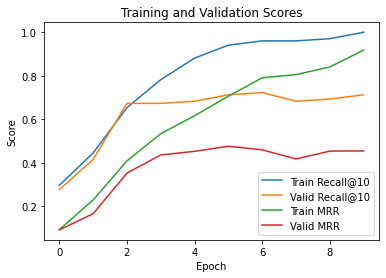

In [4]:
# Plot results
import matplotlib.pyplot as plt
plt.plot(train_recall, label='Train Recall@10')
plt.plot(valid_recall, label='Valid Recall@10')
plt.plot(train_mrr, label='Train MRR')
plt.plot(valid_mrr, label='Valid MRR')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training and Validation Scores')
plt.legend()
plt.savefig('qa_scores.png')
plt.show()

In [5]:
"""
Select 3 pairs from the validation set, and run your model on those 3 examples. This time, you will retrieve from all answers (answers.csv). Then, paste the question title, body, true answer and the predicted answer in the text boxes below, using the following format:

Question Title: <write your question title here>
Question Body: <write your question body here>
True Answer: <the answer associated in the validation.csv>
Predicted Answer: <what was retrieved by your model>
"""
# Select 3 pairs from the validation set
q_titles = qa_data['valid'].loc[0 : 2, 'QuestionTitle'].tolist()
q_bodies = qa_data['valid'].loc[0 : 2, 'QuestionBody'].tolist()
answers = qa_data['valid'].loc[0 : 2, 'Answer'].tolist()
# Tokenize batch and get class output
q_batch, a_batch = tokenize_qa_batch(tokenizer, q_titles, q_bodies, answers)
q_batch = q_batch.to(device)
a_batch = a_batch.to(device)

q_out = get_class_output(q_enc, q_batch)
a_out = get_class_output(a_enc, a_batch)

# Get top-k indices
indices, scores = get_topk_indices(q_out, a_out, k=10)
indices = indices.cpu().tolist()
# Select by indices
selected = select_by_indices(indices, qa_data['answers']['Answer'].tolist())

# print results
for i, (title, body, true_answer, predicted_answers) in enumerate(zip(q_titles, q_bodies, answers, selected)):
    print(f"Question Title: {title}")
    print(f"Question Body: {body}")
    print(f"True Answer: {true_answer}")
    print(f"Predicted Answer: {predicted_answers}")
    print()

Question Title: Office (Loose Leaf) Tea Solution
Question Body: I am looking for a good system to make loose leaf tea at my workplace. The main requirements are that the tea tastes good and it is easy to clean in the toilet sink without much equipment. Bonus points if it's microwaveable, since I find that slightly more practical than an electric kettle.


I have considered:


* cup with a ceramic or glass strainer. Doubts: is the mesh fine enough, or would it let the smaller leaves through?
* steel strainers. Doubts: do they affect the water taste? Can they be closed tightly, or would they let the smaller leaves through? Is the steel mesh microwavreable?
* cotton strainers. Doubts: do they dry in a reasonable time? Do they get dark and dirty after a few uses?
* fillable disposable tea bags. Doubts: are they viable for a single person? They look quite expensive
* French press, ingenuitea, or other similar contraptions. Doubts: they don't look easy to clean at all. Are they microwaveable